<a href="https://colab.research.google.com/github/OmarMachuca851/Task/blob/main/CNN_1D_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Neural Network 1D (CNN 1D) scratch**

In [1]:
import numpy as np
import math
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
class FC:
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
    def forward(self, X):
        self.X = X
        A = X@self.W + self.B
        return A
    def backward(self, dA):
        dZ = dA@self.W.T
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X.T@dA
        self.optimizer.update(self)
        return dZ


class Sigmoid:
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    def backward(self, dZ):
        _sig = self.sigmoid(self.A)
        return dZ * (1 - _sig)*_sig
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

class Tanh:
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

class Softmax:
    def forward(self, X):
        self.Z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return self.Z
    def backward(self, Y):
        self.loss = self.loss_func(Y)
        return self.Z - Y
    def loss_func(self, Y, Z=None):
        if Z is None:
            Z = self.Z
        return (-1)*np.average(np.sum(Y*np.log(Z), axis=1))

class ReLU:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)


class SGD:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1
    def update(self, layer):
        self.HW += layer.dW**2
        self.HB += layer.dB**2
        layer.W -= self.lr * np.sqrt(1/self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1/self.HB) * layer.dB
        return layer


class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(1 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

class HeInitializer():
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B


class SimpleInitializer:
    def __init__(self, sigma, seed=None):
        self.sigma = sigma
        if seed is not None:
            np.random.seed(seed)
    def W(self, *shape):
        W = self.sigma * np.random.randn(*shape)
        return W
    def B(self, *shape):
        B = self.sigma * np.random.randn(*shape)
        return B

## Problema 1: Creación de una clase de capa convolucional unidimensional con un número de canales limitado a 1

In [3]:
class SimpleConv1d():
    def forward(self, x, w, b):
        a = []
        for i in range(len(w) - 1):
            a.append((x[i:i+len(w)] @ w) + b[0])
        return np.array(a)
    def backward(self, x, w, da):
        db = np.sum(da)
        dw = []
        for i in range(len(w)):
            dw.append(da @ x[i:i+len(da)])
        dw = np.array(dw)
        dx = []
        new_w = np.insert(w[::-1], 0, 0)
        new_w = np.append(new_w, 0)
        for i in range(len(new_w)-1):
            dx.append(new_w[i:i+len(da)] @ da)
        dx = np.array(dx[::-1])
        return db, dw, dx

## Problema 2: Cálculo del tamaño de salida después de la convolución 1D

In [4]:
def output_size_calculation(n_in, F, P=0, S=1):
    n_out = int((n_in + 2*P - F) / S + 1)

    return n_out

## Problema 3: Experimento con capas convolucionales 1D en matrices pequeñas

In [5]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
b = np.array([1])

conv = SimpleConv1d()

# Forward
a = conv.forward(x, w, b)
print('forward output: ', a)

# Backward
da = np.array([10, 20])
db, dW, dx = conv.backward(x, w, da)

print('dW: ', dW)
print('db: ', db)
print('dx: ', dx)

forward output:  [35 50]
dW:  [ 50  80 110]
db:  30
dx:  [ 30 110 170 140]


## Problema 4: Creación de una clase de capa convolucional 1D con un número ilimitado de canales

In [6]:
class Conv1d:
    def __init__(self, b_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, stride=1):
        self.b_size = b_size
        self.optimizer = optimizer
        self.pa = pa
        if initializer is not None:
            self.W = initializer.W(n_out_channels, n_in_channels, b_size)
            self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out = None
        self.stride = stride

    def forward(self, X):
        self.n_samples = X.shape[0]
        if len(X.shape) > 1:
            self.n_in = X.shape[-1]
        else: self.n_in = 1
        self.n_out = output_size_calculation(self.n_in, self.b_size, self.pa, self.stride)
        X = X.reshape(self.n_samples, self.n_in_channels, self.n_in)
        self.X = np.pad(X, ((0,0), (0,0), ((self.b_size-1), 0)))
        self.X1 = np.zeros((self.n_samples, self.n_in_channels, self.b_size, self.n_in+(self.b_size-1)))
        for i in range(self.b_size):
            self.X1[:, :, i] = np.roll(self.X, -i, axis=-1)
        A = np.sum(self.X1[:, np.newaxis, :, :, self.b_size-1-self.pa:self.n_in+self.pa:self.stride]*self.W[:, :, :, np.newaxis], axis=(2, 3)) + self.B.reshape(-1,1)
        return A

    def backward(self, dA):
        self.dW = np.sum(dA[:, :, np.newaxis, np.newaxis]*self.X1[:, np.newaxis, :, :, self.b_size-1-self.pa:self.n_in+self.pa:self.stride], axis=(0, -1))
        self.dB = np.sum(dA, axis=(0, -1))
        self.dA = np.pad(dA, ((0,0), (0,0), (0, (self.b_size-1))))
        self.dA1 = np.zeros((self.n_samples, self.n_out_channels, self.b_size, self.dA.shape[-1]))
        for i in range(self.b_size):
            self.dA1[:, :, i] = np.roll(self.dA, i, axis=-1)
        dX = np.sum(self.W[:, :, :, np.newaxis]*self.dA1[:, :, np.newaxis], axis=(1,3))
        if self.optimizer is not None:
            self.optimizer.update(self)
        return dX

## Problema 5: Implementación del relleno

In [7]:
def pad1d(x, pad_width, mode='constant'):
    return np.pad(x, pad_width, mode=mode)

# Running an example to see output
x = np.array([1, 2, 3, 4, 5, 6, 7])
print('padded: ', pad1d(x, (3, 3)))

padded:  [0 0 0 1 2 3 4 5 6 7 0 0 0]


## Problema 6: manejo de Minibatch

In [8]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = int(np.ceil(X.shape[0]/self.batch_size))

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## [Problema 7] Cualquier número de pasos

`Conv1d(3, SimpleInitializer(0.01, seed=123), SGD(0.01), n_out_channels=1, n_in_channels=1,` **`stride=1)`**

In [9]:
x = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9]])

cv_stride1 = Conv1d(3, SimpleInitializer(0.01, seed=123), SGD(0.01), n_out_channels=1, n_in_channels=1, stride=1)
print(cv_stride1.B)
print(cv_stride1.W)
print('________________________________________________________________________________')
forward_stride1 = cv_stride1.forward(x)
print(f'\nstride 1: shape({forward_stride1.shape})\n{forward_stride1}')
da1 = np.array([[[10, 20, 30, 40, 50, 60, 70]]])
dx = cv_stride1.backward(da1)
print('dx:\n',dx)
print('db: \n', cv_stride1.dB)
print('dw: \n', cv_stride1.dW)

print('________________________________________________________________________________')

cv_stride2 = Conv1d(3, SimpleInitializer(0.01, seed=123), SGD(0.01), n_out_channels=1, n_in_channels=1, stride=2)
forward_stride2 = cv_stride2.forward(x)
print(f'\nstride 2: shape({forward_stride2.shape})\n{forward_stride2}')
da2 = np.array([[[10, 20, 30, 40]]])
dx = cv_stride2.backward(da2)
print('dx:\n',dx)
print('db: \n', cv_stride2.dB)
print('dw: \n', cv_stride2.dW)

print('________________________________________________________________________________')

cv_stride3 = Conv1d(3, SimpleInitializer(0.01, seed=123), SGD(0.01), n_out_channels=1, n_in_channels=1, stride=3)
forward_stride3 = cv_stride3.forward(x)
print(f'\nstride 3: shape({forward_stride3.shape})\n{forward_stride3}')
da3 = np.array([[[10, 20, 30]]])
dx = cv_stride3.backward(da3)
print('dx:\n',dx)
print('db: \n', cv_stride3.dB)
print('dw: \n', cv_stride3.dW)

[-0.01506295]
[[[-0.01085631  0.00997345  0.00282978]]]
________________________________________________________________________________

stride 1: shape((1, 1, 7))
[[[0.00251701 0.00446394 0.00641088 0.00835781 0.01030474 0.01225168
   0.01419861]]]
dx:
 [[[-0.10856306 -0.11739158 -0.09792224 -0.07845291 -0.05898357
   -0.03951424 -0.02004491  0.86792891  0.19808495]]]
db: 
 [280]
dw: 
 [[[1400. 1680. 1960.]]]
________________________________________________________________________________

stride 2: shape((1, 1, 4))
[[[0.00251701 0.00641088 0.01030474 0.01419861]]]
dx:
 [[[-0.10856306 -0.11739158 -0.09792224 -0.07845291  0.48383173
    0.1131914 ]]]
db: 
 [100]
dw: 
 [[[500. 600. 700.]]]
________________________________________________________________________________

stride 3: shape((1, 1, 3))
[[[0.00251701 0.00835781 0.01419861]]]
dx:
 [[[-0.10856306 -0.11739158 -0.09792224  0.35579933  0.08489355]]]
db: 
 [60]
dw: 
 [[[300. 360. 420.]]]


In [10]:
class ScratchCNNClassifier:
    def __init__(self, num_epoch=10, lr=0.01, batch_size=20, n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, verbose=True, Activater=Tanh, Optimizer=AdaGrad):
        self.num_epoch = num_epoch
        self.lr = lr
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.Activater = Activater
        if Activater == Sigmoid or Activater == Tanh:
            self.Initializer = XavierInitializer
        elif Activater == ReLU:
            self.Initializer = HeInitializer
        self.Optimizer = Optimizer

        # for learning curve
        self.train_loss = []
        self.val_loss = []

    def forward_propagation(self, X):
        A1 = self.Conv1d.forward(X)
        A1 = A1.reshape(A1.shape[0], A1.shape[-1])
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3

    def back_propagation(self,y_true):
        dA3 = self.activation3.backward(y_true)
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dA1 = dA1[:, np.newaxis]
        dZ0 = self.Conv1d.backward(dA1)

    def fit(self, X, y, X_val=None, y_val=None):
        self.Conv1d = Conv1d(b_size=7, initializer=SimpleInitializer(0.01), optimizer=self.Optimizer(self.lr), n_in_channels=1, n_out_channels=1, pa=1, stride=1)
        self.Conv1d.n_out = output_size_calculation(X.shape[-1], self.Conv1d.b_size, self.Conv1d.pa, self.Conv1d.stride)
        self.activation1 = self.Activater()
        self.FC2 = FC(1*self.Conv1d.n_out, self.n_nodes2, self.Initializer(), self.Optimizer(self.lr))
        self.activation2 = self.Activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.Initializer(), self.Optimizer(self.lr))
        self.activation3 = Softmax()
        self.loss = []
        self.loss_epoch = [self.activation3.loss_func(y, self.forward_propagation(X))]
        for epoch in range(self.num_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X, mini_y in get_mini_batch:
                self.forward_propagation(mini_X)
                self.back_propagation(mini_y)
                self.loss.append(self.activation3.loss)
            self.loss_epoch.append(self.activation3.loss_func(y, self.forward_propagation(X)))

            if self.verbose:
                print(f'Epoch {epoch+1}/{self.num_epoch}, Train Loss: {self.loss_epoch[-1]:.4f}')

    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=1)

In [11]:
def load_and_preprocess_data():
    # Loading MNIST data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    #X_train, y_train, X_test, y_test = X_train[:6000], y_train[:6000], X_test[:1000], y_test[:1000]
    # Preprocessimg
    X_train = X_train.reshape(-1, 784).astype(np.float32) / 255
    X_test = X_test.reshape(-1, 784).astype(np.float32) / 255

    # One-hot encode labels
    from packaging.version import Version
    import sklearn

    if Version(sklearn.__version__) >= Version('1.2'):
        enc  = OneHotEncoder(sparse_output=False)
    else:
        enc = OneHotEncoder(sparse=False)

    y_train_one_hot = enc.fit_transform(y_train.reshape(-1, 1))
    y_test_one_hot = enc.transform(y_test.reshape(-1, 1))

    # Splitting into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    #y_val_labels = np.argmax(y_val, axis=1)
    accuracy = np.mean(y_pred == y_val)
    print(f'Validation Accuracy: {accuracy:.4f}')

    # Plotting learning curve
    plt.figure(figsize=(10, 5))
    plt.plot(model.loss_epoch, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid()
    plt.show()

def visualize_misclassications(model, X_val, y_val, num=49):
    y_pred = model.predict(X_val)
    #y_val_labels = np.argmax(y_val, axis=1)

    true_false = y_pred == y_val
    false_list = np.where(true_false == False)[0].astype(int)

    if false_list.shape[0] < num:
        num = false_list.shape[0]

    fig = plt.figure(figsize=(7, 7))
    fig.subplots_adjust(left=0, right=0.8, bottom=0, top=0.8, hspace=1, wspace=0.5)

    for i in range(num):
        ax = fig.add_subplot(7, 7, i+1, xticks=[], yticks=[])
        ax.set_title(f'{y_pred[false_list[i]]} / {y_val[false_list[i]]}')
        ax.imshow(X_val.reshape(-1, 28, 28)[false_list[i]], cmap='gray')

    plt.show()

# Loading and preprocesing data
X_train, y_train, X_val, y_val, X_test, y_test = load_and_preprocess_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
cnn = ScratchCNNClassifier(num_epoch=5, lr=0.01, batch_size=20, n_features=784, n_nodes1=400, n_nodes2=400, n_output=10, verbose=True, Activater=Sigmoid, Optimizer=SGD)
cnn.fit(X_train, y_train)

y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

Epoch 1/5, Train Loss: 0.2716
Epoch 2/5, Train Loss: 0.1936
Epoch 3/5, Train Loss: 0.1505
Epoch 4/5, Train Loss: 0.1230
Epoch 5/5, Train Loss: 0.1038


0.9652

Validation Accuracy: 0.9652


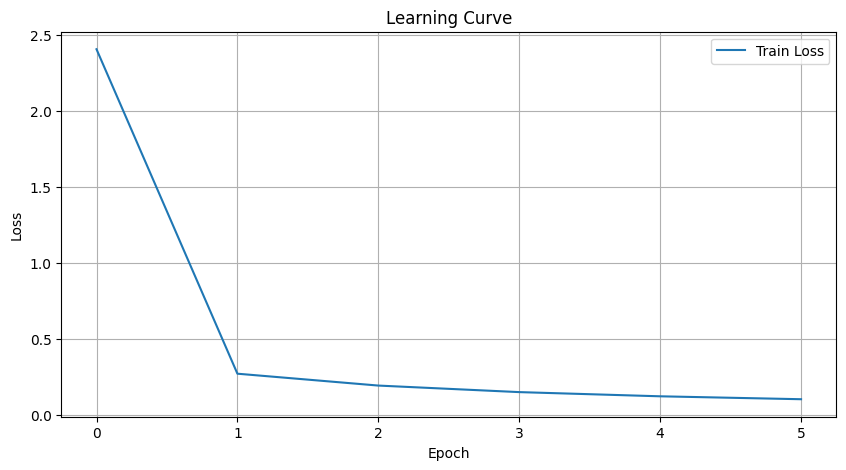

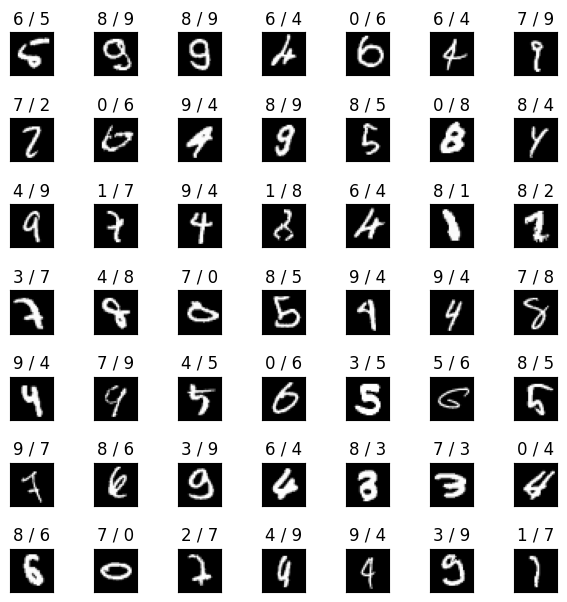

In [14]:
evaluate_model(cnn, X_test, y_test)
visualize_misclassications(cnn, X_test, y_test)